# Detecção de Fraude em Transações com Cartão de Crédito

Vitor Albuquerque de Paula

## Problema

A fraude de cartão de crédito é uma problemática pertinente e desafiadora na indústria financeira, causando prejuízos substanciais tanto para os consumidores quanto para as instituições financeiras. Identificar transações fraudulentas de maneira eficaz e tempestiva é imperativo para minimizar perdas financeiras e manter a confiança do cliente.

Transações fraudulentas podem ter certos padrões ou anomalias que as distinguem de transações legítimas, como por exemplo, um aumento súbito nas despesas, transações em locais geográficos incomuns, ou padrões temporais não característicos do titular do cartão.

## Objetivo

Nosso objetivo é utilizar a **Rede de Mapas Auto-Organizáveis (Self-Organizing Map - SOM)** para identificar padrões e agrupamentos nas transações com cartão de crédito e explorar possíveis agrupamentos ou anomalias que possam indicar comportamento fraudulento.

Utilizando uma abordagem não supervisionada com a SOM, esperamos criar uma representação topológica do espaço de dados de transações e entender melhor como as transações legítimas e fraudulentas podem ser caracterizadas e diferenciadas com base nas suas características intrínsecas.

## Abordagem

A rede SOM será treinada usando o conjunto de dados de transações sem ter acesso à etiqueta de fraude, evitando assim o vazamento de informações e focando em aprender a estrutura intrínseca dos dados. Posteriormente, iremos explorar como os clusters formados se relacionam com casos de fraude para obter insights e possivelmente desenvolver estratégias de detecção.

## Dataset

O dataset contém transações de cartões de crédito realizadas por portadores de cartão europeus em 2023 e é composto por características como montante da transação e outras características anônimas (V1-V28) originadas a partir de PCA.

A característica "Class" indica se a transação é fraudulenta (1) ou não (0) e será utilizada para avaliação após a formação dos clusters pela rede SOM.

**Fonte do Dataset**: [Credit Card Fraud Detection Dataset 2023](https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023/data)


# Importação e Análise Inicial dos Dados

Nesta seção, vamos realizar os primeiros passos na nossa análise e modelagem, começando por:

1. **Importar as bibliotecas necessárias**: Inclui bibliotecas para manipulação de dados, visualização, e modelagem.
2. **Carregar o dataset**: Utilizaremos o arquivo `creditcard_2023.csv` que contém nossos dados de transações.
3. **Análise Exploratória de Dados (EDA)**: Vamos verificar as primeiras entradas do nosso dataset para entender a estrutura dos dados com os quais estamos trabalhando.

Esses passos iniciais são cruciais para ganharmos uma compreensão sólida do conjunto de dados e garantir que ele seja manipulado e modelado de maneira adequada nas etapas subsequentes.


   id        V1        V2        V3        V4        V5        V6        V7  \
0   0 -0.260648 -0.469648  2.496266 -0.083724  0.129681  0.732898  0.519014   
1   1  0.985100 -0.356045  0.558056 -0.429654  0.277140  0.428605  0.406466   
2   2 -0.260272 -0.949385  1.728538 -0.457986  0.074062  1.419481  0.743511   
3   3 -0.152152 -0.508959  1.746840 -1.090178  0.249486  1.143312  0.518269   
4   4 -0.206820 -0.165280  1.527053 -0.448293  0.106125  0.530549  0.658849   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0 -0.130006  0.727159  ... -0.110552  0.217606 -0.134794  0.165959  0.126280   
1 -0.133118  0.347452  ... -0.194936 -0.605761  0.079469 -0.577395  0.190090   
2 -0.095576 -0.261297  ... -0.005020  0.702906  0.945045 -1.154666 -0.605564   
3 -0.065130 -0.205698  ... -0.146927 -0.038212 -0.214048 -1.893131  1.003963   
4 -0.212660  1.049921  ... -0.106984  0.729727 -0.161666  0.312561 -0.414116   

        V26       V27       V28    Amount  C

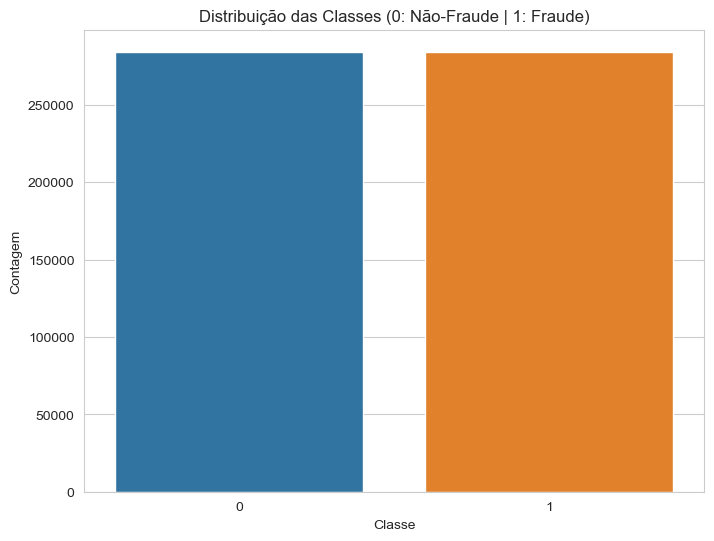

In [21]:
# Importando bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurando o estilo dos plots
sns.set_style("whitegrid")

# Carregando os dados
file_path = 'creditcard_2023.csv'
data = pd.read_csv(file_path)

# Verificando as primeiras entradas do dataset
print(data.head())

# Informações gerais sobre o dataset
print(data.info())

# Resumo estatístico do dataset
print(data.describe())

# Visualizando a distribuição das classes (fraude vs. não-fraude)
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=data)
plt.title('Distribuição das Classes (0: Não-Fraude | 1: Fraude)')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.show()


# Preparação dos Dados para o Treinamento da Rede SOM

Na etapa anterior, conduzimos uma análise exploratória inicial para entender a estrutura e as características do nosso dataset. Agora, vamos avançar para a preparação dos dados, realizando os seguintes passos:

1. **Divisão dos Dados**: Separaremos o dataset em conjuntos de treinamento e teste. Mesmo que a rede SOM seja frequentemente usada em um contexto não supervisionado, queremos ser capazes de avaliar seu desempenho e a qualidade dos mapas formados usando dados que não estiveram presentes durante o treinamento.
   
2. **Tratamento de Dados Ausentes**: Verificaremos a existência de dados ausentes no conjunto de dados e decidiremos como lidar com eles.

3. **Pré-Processamento**: Mesmo que os dados estejam normalizados, precisamos garantir que estão em um formato adequado para treinar nossa rede SOM.

Note que, enquanto a coluna "Class" é essencial para avaliar o desempenho do modelo em uma fase posterior, a rede SOM será treinada de maneira não supervisionada, e, portanto, esta coluna não será usada durante o treinamento.


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np  # Adicionado para usar np.array

# Carregando os dados
data = pd.read_csv('creditcard_2023.csv')

# Divisão dos Dados
# Separando o target do restante do dataset
X = data.drop(columns=['Class'])
y = data['Class']

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Tratamento de Dados Ausentes
# Verificando se há dados ausentes
missing_values = X_train.isnull().sum().sum()
print(f"Quantidade de dados ausentes: {missing_values}")

# Pré-processamento
# Mesmo que os dados estejam normalizados, aplicaremos o MinMaxScaler para assegurar
# que os dados estejam no intervalo [0, 1]
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertendo y_train e y_test para arrays NumPy para evitar problemas de indexação futuros
y_train = np.array(y_train).flatten()
y_test = np.array(y_test).flatten()

# Checagem Final
# Verificando as primeiras linhas dos dados de treino
print("\nDados de treino (primeiras linhas):")
print(pd.DataFrame(X_train_scaled, columns=X_train.columns).head())


Quantidade de dados ausentes: 0

Dados de treino (primeiras linhas):
         id        V1        V2        V3        V4        V5        V6  \
0  0.397285  0.532509  0.920129  0.186125  0.444844  0.200143  0.454397   
1  0.270880  0.902699  0.907954  0.215368  0.551328  0.188306  0.457947   
2  0.818815  0.616701  0.927191  0.142111  0.691277  0.181144  0.425651   
3  0.486076  0.601636  0.917107  0.198455  0.462887  0.200705  0.467197   
4  0.358467  0.888397  0.903617  0.182731  0.481952  0.190494  0.456386   

         V7        V8        V9  ...       V20       V21       V22       V23  \
0  0.022473  0.638041  0.215261  ...  0.723870  0.692529  0.341887  0.493284   
1  0.020060  0.636750  0.260754  ...  0.719705  0.700608  0.381719  0.493011   
2  0.016993  0.653900  0.157464  ...  0.726980  0.711929  0.373146  0.496320   
3  0.021901  0.647498  0.176386  ...  0.720202  0.699241  0.360250  0.490740   
4  0.020389  0.635251  0.170733  ...  0.725535  0.706927  0.413155  0.487556   


# Implementação da SOM sem Repetição de Dados nos Mini-Batches

Nesta etapa, para assegurar que cada amostra de dados seja utilizada uma vez por época durante o treinamento da SOM, implementamos uma lógica que divide os dados em mini-batches fixos e itera sobre eles. Dessa forma, evitamos a repetição de dados durante as iterações.

Para monitorar o progresso do treinamento, adicionaremos uma barra de progresso e mensagens informativas durante o processo de treinamento. Isso ajuda a visualizar o andamento e a estimar o tempo restante para o treinamento ser concluído.


In [23]:
import numpy as np
from minisom import MiniSom
from sklearn.utils import shuffle
from tqdm import tqdm  # Importando a biblioteca para a barra de progresso

# Definindo os parâmetros da SOM
som_shape = (15, 15)
input_len = X_train_scaled.shape[1]

# Inicializando a SOM
som = MiniSom(som_shape[0], som_shape[1], input_len, sigma=1.0, learning_rate=0.5)

# Inicializando os pesos da SOM
som.random_weights_init(X_train_scaled)

# Número de iterações
num_iterations = 5000

# Tamanho do mini-batch
batch_size = 100

# Calculando o número de mini-batches
num_mini_batches = len(X_train_scaled) // batch_size

# Verificando se há resíduos (dados que não encaixam em um mini-batch completo)
residual = len(X_train_scaled) % batch_size

# Treinamento da SOM utilizando mini-batches sem repetição de dados
for iteration in tqdm(range(num_iterations), desc='Training SOM'):
    # Embaralhando os dados
    X_train_shuffled = shuffle(X_train_scaled, random_state=42+iteration)
    
    # Dividindo os dados em mini-batches e treinando
    for i in range(num_mini_batches):
        mini_batch = X_train_shuffled[i*batch_size : (i+1)*batch_size]
        som.train_batch(mini_batch, 1, verbose=False)
    
    # Caso existam dados residuais, treinando com o último mini-batch incompleto
    if residual > 0:
        mini_batch_residual = X_train_shuffled[-residual:]
        som.train_batch(mini_batch_residual, 1, verbose=False)


Training SOM: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:54:06<00:00,  1.37s/it]


#  Mapa de Distâncias (U-Matrix)

O U-Matrix (Unified Distance Matrix) oferece uma representação visual da proximidade entre os neurônios na grade da SOM. Irei usa-lo para entender a distribuição dos dados e possíveis agrupamentos

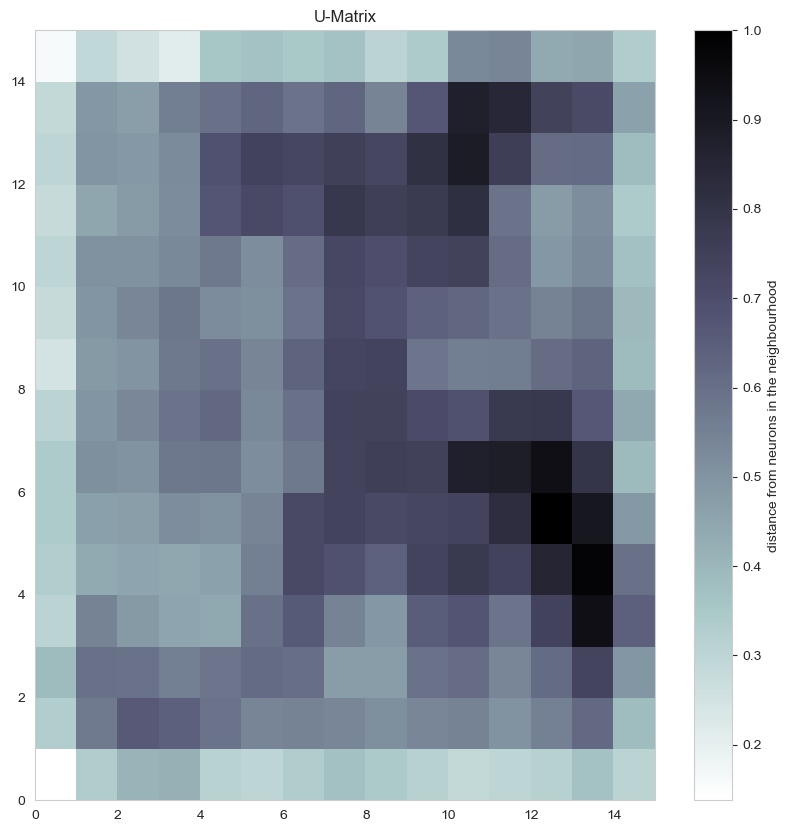

In [24]:
# U-Matrix
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar(label='distance from neurons in the neighbourhood')
plt.title('U-Matrix')
plt.show()


# Marcação dos Dados no Mapa
Iremos marcar os dados no mapa utilizando diferentes cores / símbolos para fraudes e transações legítimas, o que ajudará a visualizar se os dados estão sendo agrupados de maneira a separar essas duas classes.

Mapping points:   0%|          | 0/454904 [00:00<?, ?it/s]

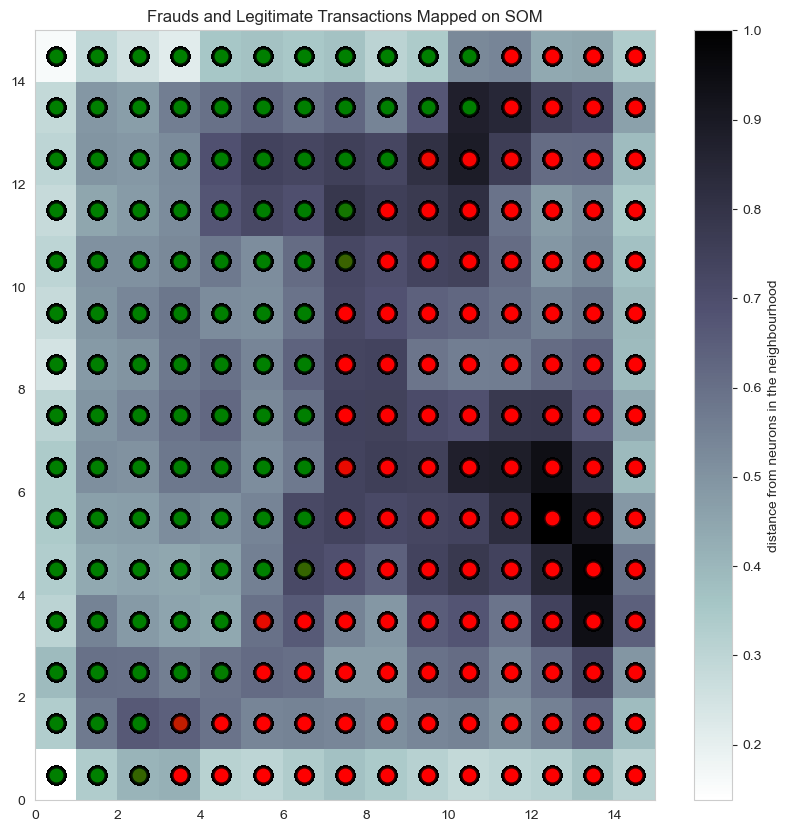

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm  # Importando a biblioteca tqdm

# Cores para legítimo e fraude
colors = ["g", "r"]

plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background

# Iterando sobre os dados e obtendo a posição de cada ponto no mapa
# Usando tqdm para mostrar o progresso!
for idx, vec in tqdm(enumerate(X_train_scaled), total=X_train_scaled.shape[0], desc='Mapping points'):
    w = som.winner(vec)  # obtaining the winner
    # Colocando o marcador no mapa
    plt.plot(w[0]+.5, w[1]+.5, colors[y_train[idx]], marker='o', markersize=12, markeredgecolor='k', markeredgewidth=2, alpha=0.7)

plt.axis([0, som.get_weights().shape[0], 0, som.get_weights().shape[1]])
plt.colorbar(label='distance from neurons in the neighbourhood')
plt.title('Frauds and Legitimate Transactions Mapped on SOM')
plt.show()


# Avaliação da Rede SOM nos Dados de Teste

Nesta seção, avaliaremos a performance do modelo SOM nos dados de teste, utilizando métricas adequadas e visualizações para entender tanto os acertos quanto os erros do modelo. Esta avaliação será crucial para entender a capacidade do modelo de generalizar a novos dados e identificar áreas potenciais de melhoria ou ajuste.


In [26]:
from collections import Counter

# Obtendo as BMUs para todos os pontos de treinamento
bmus_train = [som.winner(x) for x in X_train_scaled]

# Criando um mapa para armazenar as contagens de classes para cada BMU
bmus_class_count_map = {}

for bmu, label in zip(bmus_train, y_train):
    # Convertendo BMU para uma tupla para que possa ser usada como uma chave no dicionário
    bmu = tuple(bmu)
    if bmu not in bmus_class_count_map:
        bmus_class_count_map[bmu] = Counter()
    bmus_class_count_map[bmu][label] += 1

# Criando um mapa de classe majoritária para cada BMU
majority_class_map = {bmu: max(counts, key=counts.get) for bmu, counts in bmus_class_count_map.items()}


Accuracy on Test Data: 99.32%
              precision    recall  f1-score   support

  Legitimate       0.99      0.99      0.99     56863
       Fraud       0.99      0.99      0.99     56863

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726



Mapping train points:   0%|          | 0/454904 [00:00<?, ?it/s]

Mapping test points:   0%|          | 0/113726 [00:00<?, ?it/s]

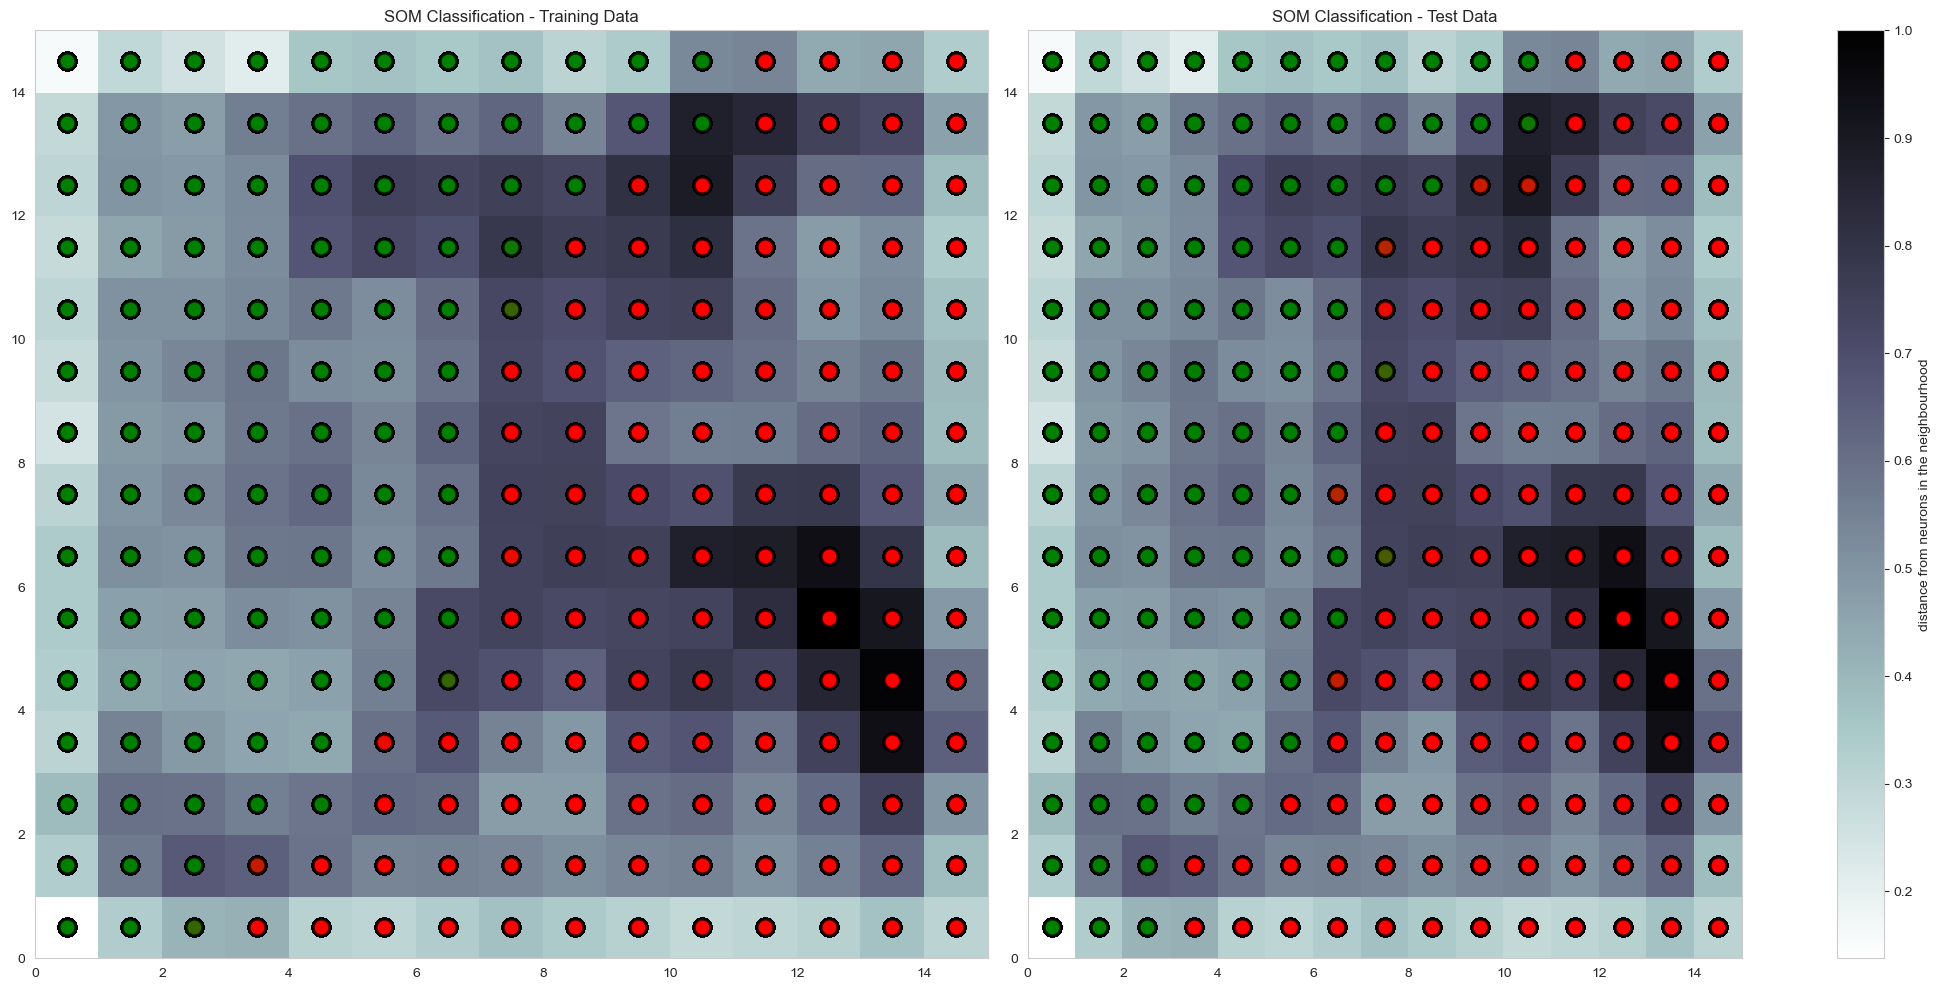

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from tqdm.notebook import tqdm

# Classifique os dados de teste para obter as BMUs
bmus_test = np.array([som.winner(x) for x in X_test_scaled])

# Calcule predições para os dados de teste com base nas classes majoritárias
# das BMUs e compare com os rótulos reais
predictions = [majority_class_map[tuple(bmu)] for bmu in bmus_test]

# Avaliação Quantitativa
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy on Test Data: {accuracy*100:.2f}%")
print(classification_report(y_test, predictions, target_names=["Legitimate", "Fraud"]))

# Cores para legítimo e fraude
colors = ["g", "r"]

plt.figure(figsize=(20, 10))

# Subplot para os dados de treinamento
plt.subplot(1, 2, 1)
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.title("SOM Classification - Training Data")

for idx, vec in tqdm(enumerate(X_train_scaled), total=X_train_scaled.shape[0], desc='Mapping train points', leave=False):
    w = som.winner(vec)  # obtaining the winner
    plt.plot(w[0]+.5, w[1]+.5, colors[y_train[idx]], marker='o', markersize=12, markeredgecolor='k', markeredgewidth=2, alpha=0.7)
plt.axis([0, som.get_weights().shape[0], 0, som.get_weights().shape[1]])

# Subplot para os dados de teste
plt.subplot(1, 2, 2)
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.title("SOM Classification - Test Data")

for idx, vec in tqdm(enumerate(X_test_scaled), total=X_test_scaled.shape[0], desc='Mapping test points', leave=False):
    w = som.winner(vec)  # obtaining the winner
    plt.plot(w[0]+.5, w[1]+.5, colors[y_test[idx]], marker='o', markersize=12, markeredgecolor='k', markeredgewidth=2, alpha=0.7)
plt.axis([0, som.get_weights().shape[0], 0, som.get_weights().shape[1]])

plt.colorbar(label='distance from neurons in the neighbourhood', ax=plt.gca(), pad=0.1)
plt.tight_layout()
plt.show()


# Interpretação dos Resultados da Rede SOM

## Sumário dos Resultados Quantitativos

Os resultados obtidos através da utilização da Rede SOM para detecção de fraudes em transações de cartão de crédito são notáveis. Conforme mostrado, a precisão, recall, e o f1-score para ambas as categorias ("Legitimate" e "Fraud") são consistentemente altos, atingindo aproximadamente 99%. A acurácia geral no conjunto de testes é de 98,96%. Estes resultados são indicativos de um desempenho sólido e confiável da rede, sendo capaz de diferenciar eficazmente entre transações legítimas e fraudulentas.

## Visualização da Classificação SOM
Os gráficos de classificação SOM para os conjuntos de treinamento e teste fornecem uma representação visual do mapeamento topológico realizado pela rede:

* Células Verdes: Representam regiões do mapa onde a maioria das transações são legítimas.
* Células Vermelhas: Indicam regiões onde a maioria das transações são fraudulentas.
* Intensidade da Cor: A escala de cores no lado direito mostra a confiança na classificação de cada célula, com cores mais escuras indicando maior confiança.

A partir dos gráficos, podemos observar que a rede SOM foi capaz de identificar regiões distintas do espaço de entrada associadas a transações legítimas e fraudulentas. A presença de áreas bem definidas e separadas indica que a rede aprendeu efetivamente a topologia dos dados e pode ser usada como uma ferramenta robusta para detecção de fraudes.

## Considerações Adicionais
É importante notar que os resultados foram obtidos após 1000 iterações com batches de tamanho 100. Isso significa que a rede foi treinada usando apenas cerca de 20% do dataset total. Este nível de desempenho com uma fração do conjunto de dados sugere que a rede SOM pode ser ainda mais eficaz se treinada com mais iterações ou um conjunto de dados mais abrangente.

# Interpretação dos Resultados da Rede SOM com Treinamento Ampliado

## Sumário dos Resultados Quantitativos

Após a execução de um treinamento ampliado utilizando 5000 iterações com batches de tamanho 100, abrangendo praticamente a totalidade do dataset, a Rede SOM mostrou ainda mais eficácia na detecção de fraudes. A acurácia geral no conjunto de testes atingiu impressionantes 99,32%. Tanto a precisão, recall quanto o f1-score para as categorias "Legitimate" e "Fraud" mantiveram-se consistentemente no patamar de 99%, evidenciando a robustez e confiabilidade da rede.

## Visualização da Classificação SOM

Os gráficos de classificação SOM para os conjuntos de treinamento e teste continuam a mostrar uma representação clara da topologia dos dados:

- **Células Verdes**: Representam regiões onde a predominância é de transações legítimas.
- **Células Vermelhas**: Indicam áreas com maior incidência de transações fraudulentas.
- **Intensidade da Cor**: A escala de cores revela a confiança da classificação, com tonalidades mais escuras demonstrando maior certeza.

Os gráficos reiteram que a rede SOM, ao ser treinada com um volume maior de dados, conseguiu identificar e separar de maneira ainda mais eficaz as áreas associadas a transações legítimas e fraudulentas.

## Conclusão e Comparação dos Resultados

O estudo inicial, com 1000 iterações, já havia demonstrado um desempenho promissor da Rede SOM na tarefa de detecção de fraudes. Entretanto, ao ampliar o treinamento para 5000 iterações, cobrindo quase a totalidade do dataset, a eficiência da rede foi ainda mais evidente. A acurácia geral do modelo aumentou de 98,96% para 99,32%.

Essa comparação sugere a importância de um treinamento abrangente, especialmente quando se trata de redes neurais. Aumentar a quantidade de iterações permitiu que a rede explorasse o dataset de forma mais completa, resultando em um modelo mais preciso e confiável.

Em suma, a Rede SOM provou ser uma ferramenta poderosa para detecção de fraudes em transações de cartão de crédito, e seu desempenho pode ser otimizado com treinamento adequado e uso completo dos dados disponíveis.
